## Object Localization with TensorFlow

#### Extracting emoji dataset from Github

In [ ]:
import os
import zipfile
import requests

url = "https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip"
zip_path = "openmoji-72x72-color.zip"
extract_dir = "emojis"

if not os.path.exists(zip_path):
    response = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(response.content)

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {extract_dir}")


Downloading...
Downloaded.
Extracted to: emojis


#### Importing Libraries

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D, MaxPool2D, BatchNormalization , Dropout

In [8]:
tf.__version__

'2.18.0'

#### Labeling Emojis and Visualization of Emojis

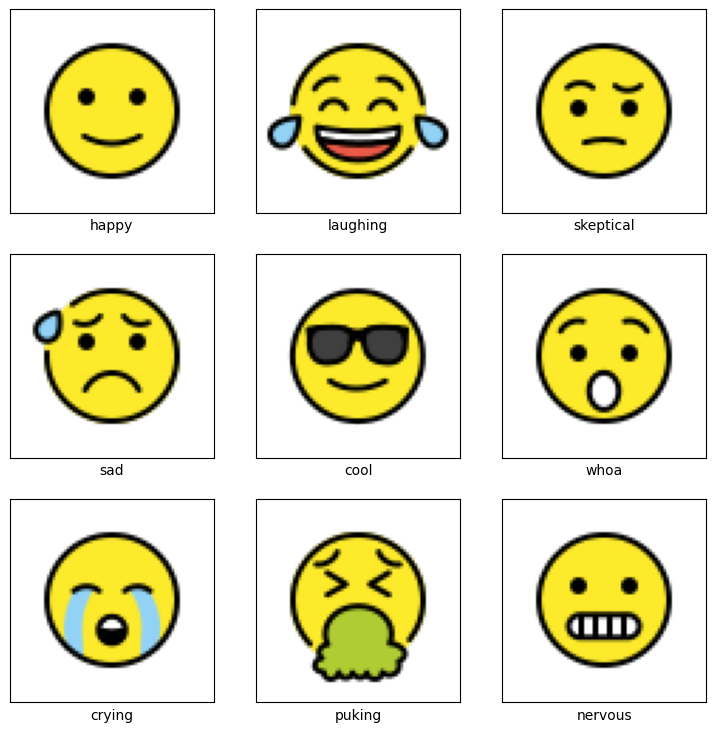

In [9]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

#### Creating random examples

now we will make a larger box and randomly place the emoji in it and the task of the model would be to locate the emoji

In [12]:
# adding the image to the dictionary
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [11]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [14]:
#randomly placing the emoji in a box
def random_placement():
    class_id  = np.random.randint(0,9)
    image = np.ones((144,144,3))*255 #emoji was 72x72
    row = np.random.randint(0,72)
    column = np.random.randint(0,72)
    image[row:row+72,column:column+72] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'),class_id, (row+10)/144,(column+10)/144 #the offset of 10 is to utilize the empty space around the emoji

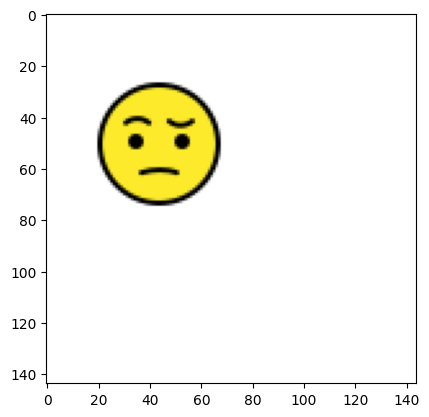

In [48]:
image,clas_id,row,column = random_placement()
plt.imshow(image)

#### Plotting Boundaries

In [49]:
def plot_boundaries(image,ground_truth_coords,predicted_coords=None,norm = False):
    if(norm): #checks if image values are normalised or not
        image =image*255
        image = image.astype('uint8')
    image =Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    row,column = ground_truth_coords
    row = row*144
    column = column*144
    draw.rectangle((column,row,column+52,row+52),outline='green',width=2)# 52 because we removed offset of 10 from both sides
    
    if predicted_coords:
        row,column = ground_truth_coords
        row = row*144
        column = column*144
        draw.rectangle((column,row,column+52,row+52),outline='red',width=2)
    
    return image

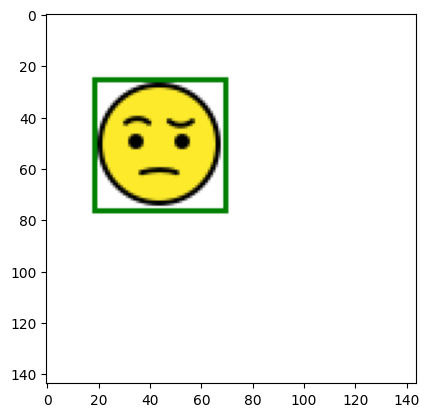

In [50]:
image = plot_boundaries(image,ground_truth_coords=[row,column])
plt.imshow(image)
plt.show()

#### Data Generation